# Import Library

In [6]:
import os
import cv2
import csv
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Setup Dataset

In [2]:
# Paths
data_path = "/kaggle/input/ff-c23/FaceForensics++_C23"
output_dir = "frames_cropped_new"
os.makedirs(output_dir, exist_ok=True)

# Debug settings
DEBUG_MODE = True
DEBUG_VIDEOS_PER_CATEGORY = 2  # number of videos per category to debug

# NEW: maksimum crops per video
MAX_CROPS_PER_VIDEO = 1

# Category-to-label mapping
categories = {
    "original": 0,
    "DeepFakeDetection": 1,
    "Deepfakes": 1,
    "Face2Face": 1,
    "FaceSwap": 1,
    "FaceShifter":1,
    "NeuralTextures": 1
}

# Cropping Face

In [3]:
# Initialize face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

# Prepare CSV rows
csv_rows = [["filepath", "label"]]

# Loop through each category and video
for category, label in tqdm(categories.items(),desc="categories"):
    print(f"\nCategory: {category}")
    processed_count = 0
    cat_path = os.path.join(data_path, category)

    for root, _, files in os.walk(cat_path):
        for file in files:
            if not file.endswith('.mp4'):
                continue
            if DEBUG_MODE and processed_count >= DEBUG_VIDEOS_PER_CATEGORY:
                break

            video_path = os.path.join(root, file)
            print(f"Processing video: {video_path}")

            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS) or 30
            interval = int(fps)  # 1 frame per second
            frame_idx = 0
            saved_idx = 0

            while True:
                ret, frame = cap.read()
                if not ret or saved_idx >= MAX_CROPS_PER_VIDEO:
                    # berhenti jika video habis atau sudah mencapai batas crop
                    break

                # Only process one frame per second
                if frame_idx % interval == 0:
                    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
                    if len(faces) > 0:
                        x, y, w, h = faces[0]  # ambil wajah pertama
                        face_crop = frame[y:y+h, x:x+w]
                        save_fname = f"{category}_{os.path.splitext(file)[0]}_{saved_idx:04d}.jpg"
                        save_path = os.path.join(output_dir, save_fname)
                        cv2.imwrite(save_path, face_crop)
                        csv_rows.append([save_path, label])
                        saved_idx += 1

                frame_idx += 1

            cap.release()
            processed_count += 1

        if DEBUG_MODE and processed_count >= DEBUG_VIDEOS_PER_CATEGORY:
            break

# Write out the labels CSV
with open("labels.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(csv_rows)

print("\nDone! Cropped frames saved in", output_dir)
print("Labels list saved to labels.csv")

categories:   0%|          | 0/7 [00:00<?, ?it/s]


Category: original
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/original/123.mp4
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/original/738.mp4

Category: DeepFakeDetection
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/DeepFakeDetection/02_09__kitchen_pan__9TDCEK1Q.mp4
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/DeepFakeDetection/02_13__exit_phone_room__CP5HFV3K.mp4

Category: Deepfakes
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/479_706.mp4
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/Deepfakes/481_469.mp4

Category: Face2Face
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/479_706.mp4
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/Face2Face/481_469.mp4

Category: FaceSwap
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/FaceSwap/479_706.mp4
Processing video: /kaggle/input/ff-c23/FaceForensics++_C23/FaceSwap/481_469.mp4

Category: FaceShifter
Proces

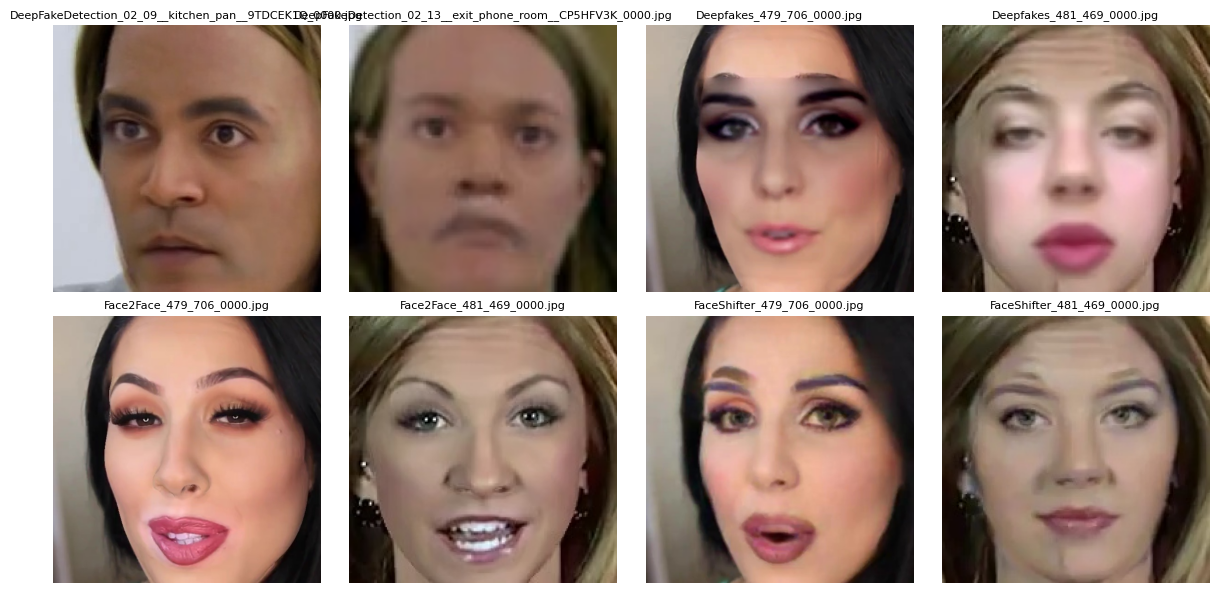

In [7]:
# Lokasi folder hasil crop
output_dir = "frames_cropped_new"

# Atur berapa banyak gambar yang mau ditampilkan
NUM_IMAGES = 8
COLS = 4

# Ambil dan sort file JPG
all_imgs = sorted([f for f in os.listdir(output_dir) if f.lower().endswith('.jpg')])
sample = all_imgs[:NUM_IMAGES]

# Hitung jumlah baris agar pas
rows = (len(sample) + COLS - 1) // COLS

# Setup figure
plt.figure(figsize=(COLS * 3, rows * 3))

# Loop dan tampilkan
for idx, fname in enumerate(sample):
    img_path = os.path.join(output_dir, fname)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    plt.subplot(rows, COLS, idx + 1)
    plt.imshow(img_rgb)
    plt.title(fname, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
df = pd.read_csv('labels.csv')
print(f"Label unique : {df['label'].unique()}\n")
print(f"Label Count: {df['label'].value_counts()}\n")
df.info()

Label unique : [0 1]

Label Count: label
1    12
0     2
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  14 non-null     object
 1   label     14 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 356.0+ bytes
